# Лекция 9. Метрики классификации

In [ ]:
#импорты
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
titanic = pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/titanic.csv')

In [ ]:
#предобработка
titanic['Sex']=titanic['Sex'].map({'male':1,'female':0})

#кодирование категориальных признаков [Pclass,Embarked]
def encode_features(df,features):
  df_encode = pd.DataFrame()
  for f in features:
    ohe = OneHotEncoder()
    ohe_arr = ohe.fit_transform(df[[f]])
    ohe_df=pd.DataFrame(ohe_arr.toarray(), columns=ohe.get_feature_names_out())
    df_encode = pd.concat([df_encode,ohe_df],axis=1)
  return df_encode
enc_features = encode_features(titanic,['Pclass','Embarked'])
titanic_df = titanic[['Survived','Sex','Age','SibSp','Parch','Fare']]
titanic_df = pd.concat([titanic_df,enc_features],axis=1)
titanic_df=titanic_df.drop([titanic_df.columns[-1]],axis=1).dropna()

In [4]:
#делим на X и Y
Y = titanic_df['Survived']
X = titanic_df.drop(['Survived'],axis=1)

In [5]:
#модель
clf_final = LogisticRegression(penalty='l2',C=0.1,solver='lbfgs',max_iter=10000)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)

## Матрица путаницы

Подробная статья о метриках - https://webiomed.ru/blog/osnovnye-metriki-zadach-klassifikatsii-v-mashinnom-obuchenii/

Матрица путаницы (сопряженности, confusion matrix) помогает в измерении производительности для классификации машинного обучения. С помощью этого типа модели можно различать и классифицировать модель с известными истинными значениями на наборе тестовых данных

Positive class - 1, Negative - 0

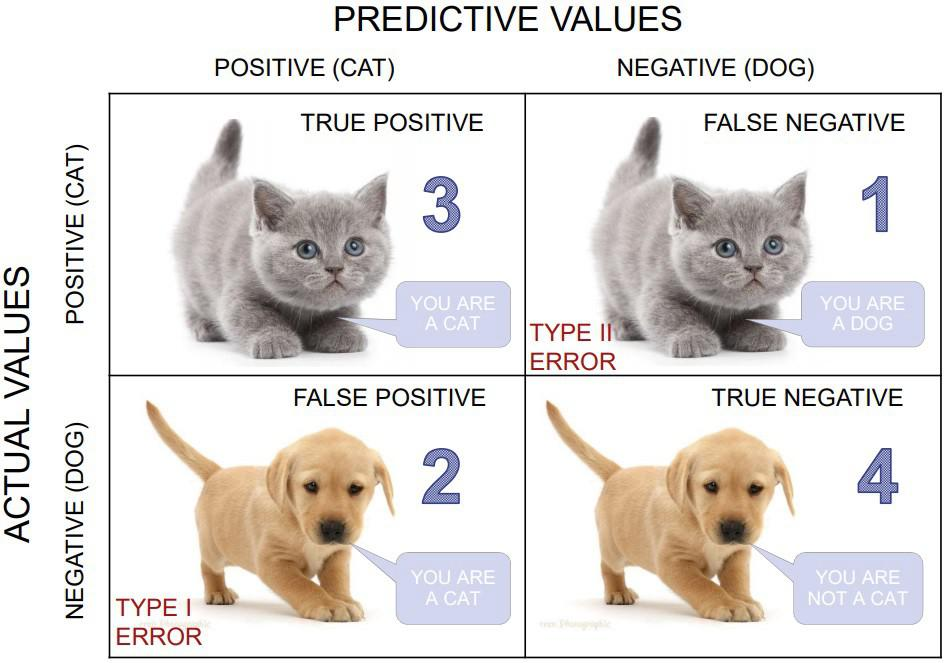

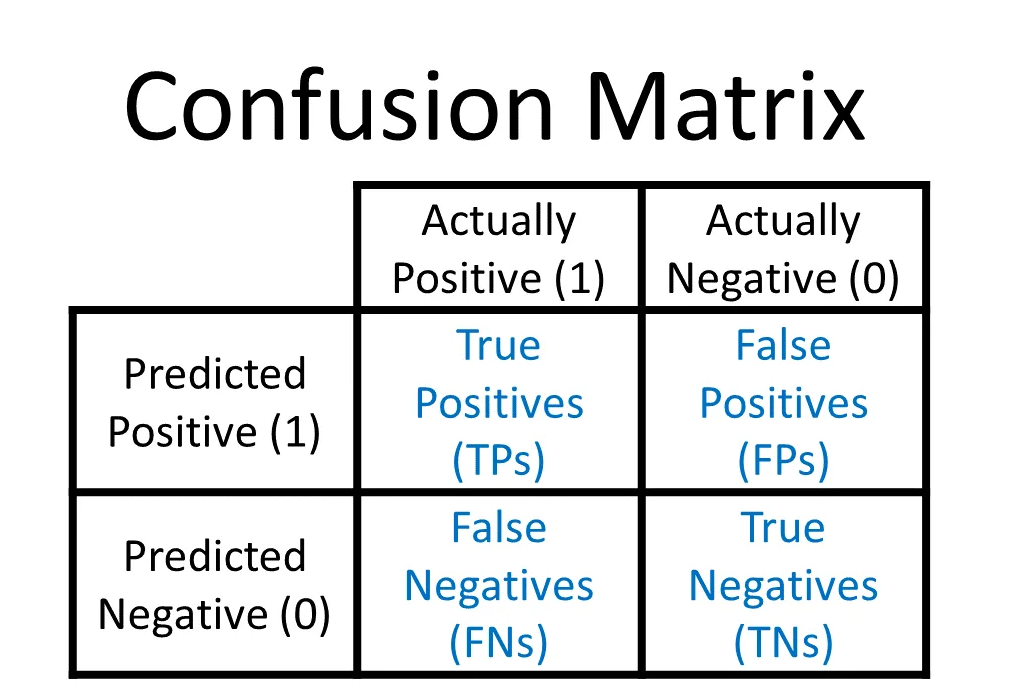

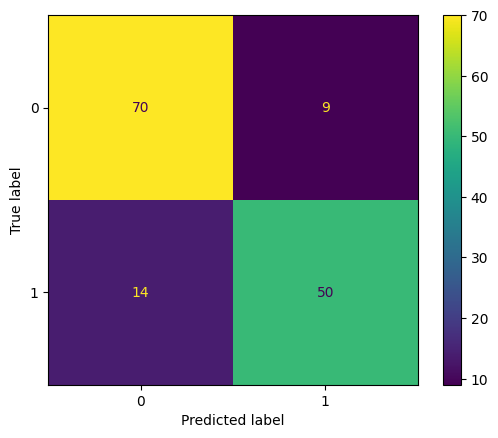

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=clf_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_final.classes_)
disp.plot()
plt.show()

## Точность (accuracy)

Интуитивно понятной, очевидной и почти неиспользуемой метрикой является accuracy — доля правильных ответов алгоритма

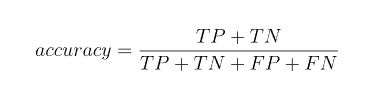

In [8]:
#считаем руками
accuracy = (70+50)/(70+50+14+9)
print(round(accuracy,2))

0.84


In [9]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.8391608391608392


Эта метрика бесполезна в задачах с неравными классами

## Precision and Recall

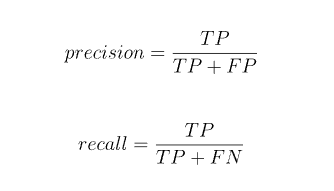

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

In [10]:
prec = 50/(50+14)
print(prec)

0.78125


In [11]:
recall = 50/(50+9)
print(recall)

0.847457627118644


In [12]:
from sklearn.metrics import precision_score,recall_score
print('Precision - ',precision_score(y_pred,y_test))
print('Recall - ',recall_score(y_pred,y_test))

Precision -  0.78125
Recall -  0.847457627118644


## Попытка подружить Recall и Precision - F-score(F-мера)

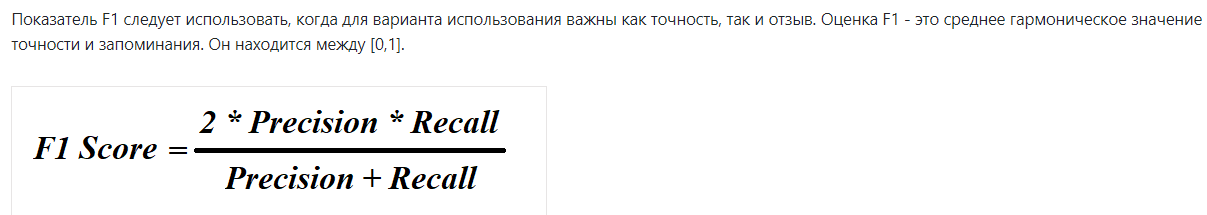

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

## Если нам важно хорошо угадывать нулевой класс - Specificity

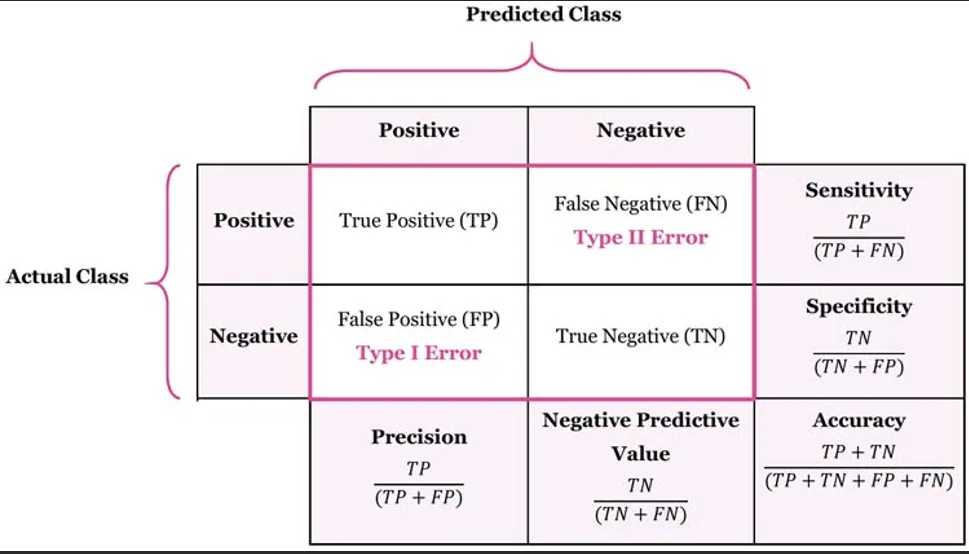

In [13]:
#специфичность - recall по нулевому классу
recall_score(y_test, y_pred, pos_label=1) #recall

0.78125

In [14]:
recall_score(y_test, y_pred, pos_label=0) #specificity

0.8860759493670886

In [ ]:
#какой вывод можно сделать?

## ROC-AUC - площадь под кривой ошибок

При конвертации вещественного ответа алгоритма в бинарную метку, мы должны выбрать какой-либо порог, при котором 0 становится 1. Естественным и близким кажется порог, равный 0.5, но он не всегда оказывается оптимальным, например, при вышеупомянутом отсутствии баланса классов.


Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является AUC-ROC (или ROC AUC) — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve ). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR):

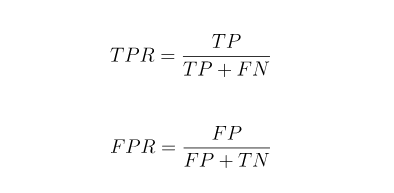

TPR нам уже известна, это полнота, а FPR показывает, какую долю из объектов negative класса алгоритм предсказал неверно. В идеальном случае, когда классификатор не делает ошибок (FPR = 0, TPR = 1) мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к 0.5, так как классификатор будет выдавать одинаковое количество TP и FP.
Каждая точка на графике соответствует выбору некоторого порога. Площадь под кривой в данном случае показывает качество алгоритма (больше — лучше), кроме этого, важной является крутизна самой кривой — мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке (0,1).

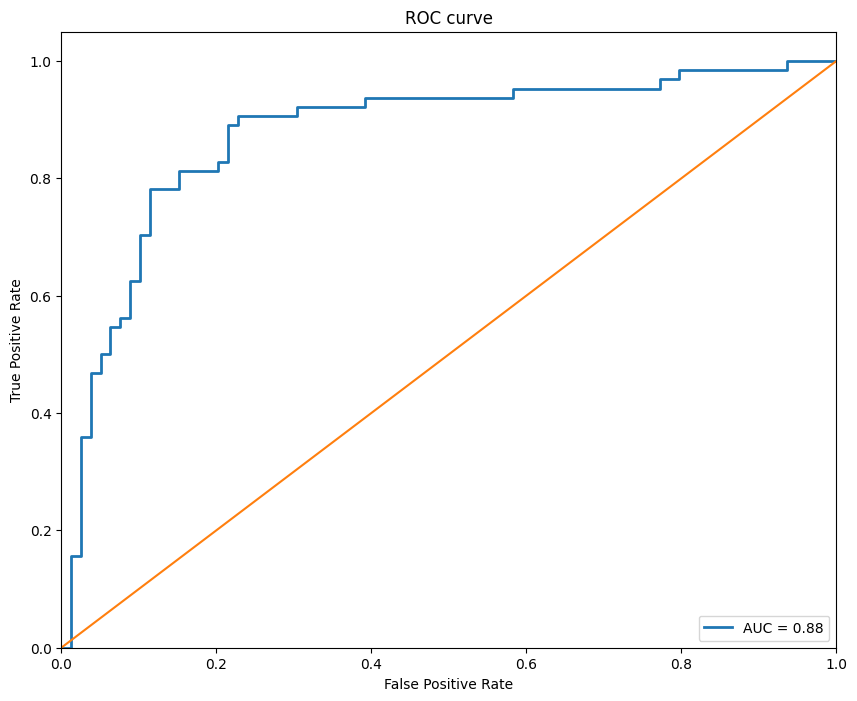

In [15]:
from sklearn.metrics import roc_curve,auc
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, clf_final.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()